This Python script initializes a Kaggle environment by importing necessary libraries like NumPy, pandas, and spaCy. It loads spaCy's large English model (`en_core_web_lg`) for natural language processing tasks and lists all files in the `/kaggle/input` directory to identify available data files.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
from sklearn.model_selection import train_test_split

# Load spaCy's large English model
nlp = spacy.load("en_core_web_lg")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


This line of code reads the CSV file spam.csv from the specified Kaggle input directory using pandas, applying the latin1 encoding to interpret the text data correctly.

In [2]:
import pandas as pd

# Try reading the CSV file with latin1 encoding
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin1')


In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


This line of code removes the columns 'Unnamed: 2', 'Unnamed: 3', and 'Unnamed: 4' from the DataFrame data in place, effectively cleaning up unnecessary columns:

In [4]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

This code snippet uses LabelEncoder from sklearn to convert the categorical values in the 'v1' column of the DataFrame data into numerical labels:

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the data
data['v1'] = label_encoder.fit_transform(data['v1'])

In [6]:
import re

This code defines a function preprocess_text to clean and preprocess text data, then applies this function to the 'v2' column of the DataFrame data to create a new column 'processed_text' containing the preprocessed text:


In [7]:
def preprocess_text(text):
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Process the text with spaCy
    doc = nlp(text)
    # Lemmatize the tokens and remove stop words
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    # Remove extra white spaces
    lemmatized_text = ' '.join(lemmatized_text.split())
    return lemmatized_text
# Apply preprocessing to the text column
data['processed_text'] = data['v2'].apply(preprocess_text)

below code defines a function text_to_vectors to convert text to vectors using spaCy, then applies this function to a DataFrame and splits the data into training and validation sets. Here is the complete implementation

In [8]:
def text_to_vectors(text):
    doc = nlp(text)
    return doc.vector

# Apply text-to-vectors conversion to the entire DataFrame
data['text_vector'] = data['processed_text'].apply(text_to_vectors)

# Split the data into train and validation sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=2020)

# Extract features and target values for train and validation sets
train_X = np.array(train_data['text_vector'])
train_y = train_data['v1']
test_X = np.array(test_data['text_vector'])
test_y = test_data['v1']


In [9]:
train_x=np.stack(train_X)
test_x=np.stack(test_X)

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on the training data and transform both training and validation data
train_X_scaled = scaler.fit_transform(train_x)
test_X_scaled = scaler.transform(test_x)

Model Training:

A neural network is defined with five layers, compiled with the Adam optimizer and binary cross-entropy loss, and trained for 300 epochs.

Evaluation:

Predictions are made on the training data, converted to binary classes, and the accuracy is calculated and printed.

In [11]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler



# Build a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_X_scaled.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_X_scaled, train_y, epochs=300, batch_size=32, verbose=1)

# Predictions on the training and validation data
train_preds = (model.predict(train_X_scaled) > 0.5).astype("int32")

# Calculate accuracy
train_accuracy = accuracy_score(train_y, train_preds)

print("Training Accuracy:", train_accuracy)



2024-06-03 12:28:44.026339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 12:28:44.026492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 12:28:44.169786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8486 - loss: 0.3790
Epoch 2/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8751 - loss: 0.2698
Epoch 3/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8990 - loss: 0.2182
Epoch 4/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8984 - loss: 0.2408
Epoch 5/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8920 - loss: 0.2366
Epoch 6/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9107 - loss: 0.2041
Epoch 7/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9201 - loss: 0.1922
Epoch 8/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9242 - loss: 0.1985
Epoch 9/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9224 - loss: 0.2057
Epoch 10/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9195 - loss: 0.1947
Epoch 11/300
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9066 - loss: 0.2119
Epoch 12/300
140/140 ━━━━━━━━━━━━━━━━━━━━

***Model Evaluation and Accuracy***:
The model makes predictions on the test data, calculates the accuracy, and prints it.

**Performance Metrics**:
A confusion matrix is plotted using Seaborn, and a detailed classification report (precision, recall, F1-score) is generated and printed for the test data.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Accuracy: 0.947085201793722


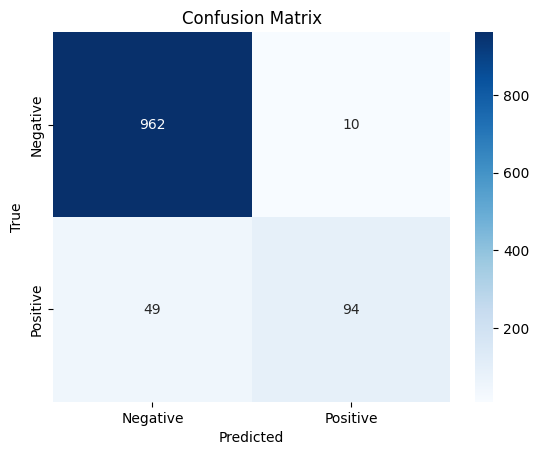

Classification Report:
               precision    recall  f1-score   support

    Negative       0.95      0.99      0.97       972
    Positive       0.90      0.66      0.76       143

    accuracy                           0.95      1115
   macro avg       0.93      0.82      0.87      1115
weighted avg       0.95      0.95      0.94      1115



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
test_preds = (model.predict(test_X_scaled) > 0.5).astype("int32")

# Calculate accuracy on the test data
test_accuracy = accuracy_score(test_y, test_preds)
print("Test Accuracy:", test_accuracy)

# Plot confusion matrix
conf_matrix = confusion_matrix(test_y, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(test_y, test_preds, target_names=['Negative', 'Positive'])
print("Classification Report:\n", class_report)